In [4]:
import sys
sys.path.append("../")

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt

In [6]:
def generate_test_data(test_df, image_type_path):
    clahe=cv2.createCLAHE(clipLimit=40)
    labels = []
    images = []
    for image_path, label in test_df[[image_type_path, "pathology"]].values:
        if image_path == "no":
            pass
        else:
            labels.append(label)
            image = cv2.imread(image_path, 0)
            gray_img_eqhist=cv2.equalizeHist(image)
            gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
            image = tf.image.resize(gray_clahe_image, (299, 299)).numpy().astype("uint8")
            images.append(image)
    return np.array(images), labels

In [7]:
train = pd.read_csv("../CBIS-DDSM/csv/combined_train_df.csv", index_col=0)
test = pd.read_csv("../CBIS-DDSM/csv/combined_test_df.csv", index_col=0)

In [8]:
new_dataset_train_path = "../image_dataset/combined_dataset/cropped_images/train/"
new_dataset_val_path = "../image_dataset/combined_dataset/cropped_images/validation/"
BATCH_SIZE = 256

tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            label_mode='categorical',
                                                            image_size=(299, 299))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                label_mode='categorical',
                                                                   image_size=(299, 299))

images, labels = generate_test_data(test, image_type_path="cropped image file path")

Found 2286 files belonging to 4 classes.
Metal device set to: Apple M1


2023-05-05 01:51:50.377237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-05 01:51:50.378208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 458 files belonging to 4 classes.


2023-05-05 01:52:14.594234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [458]
	 [[{{node Placeholder/_0}}]]
2023-05-05 01:52:14.595176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [458]
	 [[{{node Placeholder/_4}}]]


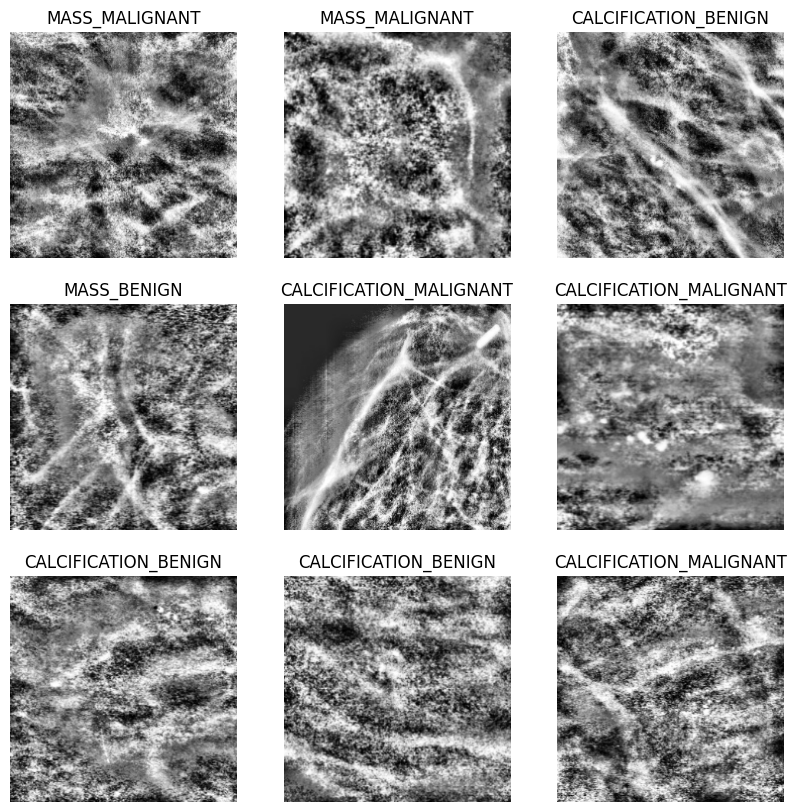

In [12]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras. layers.RandomFlip("horizontal_and_vertical")])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [8]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(299, 299, 3),  weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(299, 299, 3))

# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs, x)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [9]:
history = model.fit(tf_train_dataset,
                    epochs=100,
                    batch_size=256,
                    validation_data=tf_validation_dataset)

mets = model.evaluate(images, labels)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

Epoch 1/100


2023-05-04 23:00:34.378985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2291]
	 [[{{node Placeholder/_4}}]]
2023-05-04 23:00:34.379288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2291]
	 [[{{node Placeholder/_0}}]]
2023-05-04 23:00:36.208154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 5.8489 - accuracy: 0.2663

2023-05-04 23:00:53.554469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [789]
	 [[{{node Placeholder/_0}}]]
2023-05-04 23:00:53.555485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [789]
	 [[{{node Placeholder/_0}}]]
2023-05-04 23:00:54.396495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 27s 3s/step - loss: 5.8489 - accuracy: 0.2663 - val_loss: 1.4082 - val_accuracy: 0.2712
Epoch 2/100
9/9 [==============================] - 22s 2s/step - loss: 1.3709 - accuracy: 0.2868 - val_loss: 1.3701 - val_accuracy: 0.3080
Epoch 3/100
9/9 [==============================] - 23s 3s/step - loss: 1.3501 - accuracy: 0.3003 - val_loss: 1.3583 - val_accuracy: 0.2649
Epoch 4/100
9/9 [==============================] - 28s 3s/step - loss: 1.3280 - accuracy: 0.2846 - val_loss: 1.3453 - val_accuracy: 0.2839
Epoch 5/100
9/9 [==============================] - 27s 3s/step - loss: 1.3053 - accuracy: 0.3029 - val_loss: 1.3345 - val_accuracy: 0.2991
Epoch 6/100
9/9 [==============================] - 24s 3s/step - loss: 1.2805 - accuracy: 0.3754 - val_loss: 1.3225 - val_accuracy: 0.3105
Epoch 7/100
9/9 [==============================] - 26s 3s/step - loss: 1.2603 - accuracy: 0.3898 - val_loss: 1.3091 - val_accuracy: 0.3207
Epoch 8/100
9/9 [======================

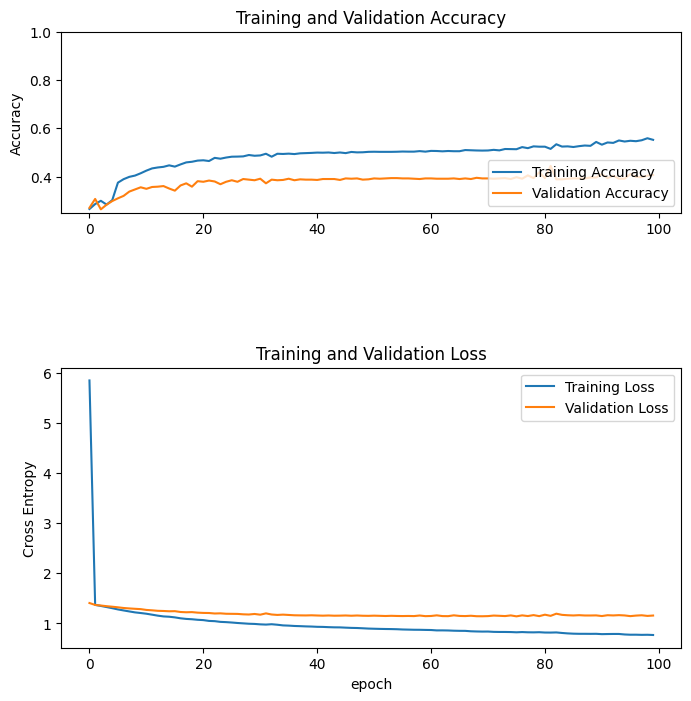

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()